**Tip:** Enable the GPU if you're running this notebook in [Colab](https://colab.research.google.com) 

* *Edit -> Notebook settings -> Hardware accellerator -> GPU*.

## Transfer learning

This notebook quickly demonstrates transfer learning. Much of the code is similar to the previous two notebooks (skim through those sections).

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os

# The code in this notebook should work identically in TF v1 and v2
import tensorflow as tf
import zipfile

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Download the dataset

In [2]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-02-10 18:56:27--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.183.128, 2607:f8b0:4001:c19::80
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.183.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   168MB/s    in 0.4s    

2019-02-10 18:56:27 (168 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [0]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [6]:
print('Training cat images:', num_cats_tr)
print('Training dog images:', num_dogs_tr)

print('Validation cat images:', num_cats_val)
print('Validation dog images:', num_dogs_val)

print("--")

print("Total training images:", total_train)
print("Total validation images:", total_val)

Training cat images: 1000
Training dog images: 1000
Validation cat images: 500
Validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


## Using a previously trained model

A common and effective approach when working with small image datasets is to leverage a pre-trained model (usually, a deep CNN trained on a large dataset like ImageNet). If the dataset the model was trained on was large, the features learned by the model may be generic enough to be useful on our classification task. Here, we will reuse VGG16 (a simple, widely used CNN). Although it's far from the current state of the art, its architecture is similar to what you've already seen. You can find other models to experiment with [here](https://www.tensorflow.org/api_docs/python/tf/keras/applications).

Let's instantiate a VGG16 model preloaded with weights trained on ImageNet.

In [7]:
# Notice we do not include the `top`, or the Dense layers used to classify the 1,000 classes from ImageNet.
conv_base = VGG16(weights='imagenet',include_top=False, input_shape=(150, 150, 3))

Instructions for updating:
Colocations handled automatically by placer.


Here's  the architecture of VGG16. It's similar to the CNNs you've already seen.

In [8]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

### Two approaches

At this point, there are two ways we could proceed:

1. Efficiently, with a caching trick. We will forward each image from our training set through VGG once, extract the activations, and cache them to memory. Later, we will use these activations as input to a Dense layer we will train to classify our data. This is efficient, since it requires forwarding the images through the convolutional base only once (this is the most expensive part of our pipeline). The downside is this prevents us from using data augmentation (which causes every image to be unqiue, preventing caching).

2. Alternatively, we could extend the VGG model by adding one or more Dense layers on top of the pretrained base. We could then run the entire model on our input data. This allows us to use data augmentation (and simplifies our code!), but this technique is quite slow by comparison (since every image we generate is unique, it will have to run through the conv_base).

We will demonstrate both techniques, starting with the first.

In [0]:
TARGET_SHAPE = 150 
BATCH_SIZE = 32

In [10]:
# Cache activations for our training and validation data
datagen = ImageDataGenerator(rescale=1./255)

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(TARGET_SHAPE, TARGET_SHAPE),
        batch_size=BATCH_SIZE,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
      
        features_batch = conv_base.predict(inputs_batch)
        # print(features_batch.shape)
        # (32, 4, 4, 512)
        # Think: batch_size, rows, cols, channels
        
        features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = features_batch
        labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = labels_batch
        i += 1
        if i * BATCH_SIZE >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


The features we've extracted from VGG are of shape (batch_size, 4, 4, 512) -- think, rows, cols, channels. We will feed these to a Dense layer, so we must flatten (or unroll) them first.

In [0]:
FLATTENED_SHAPE = 4 * 4 * 512

train_features = np.reshape(train_features, (total_train, FLATTENED_SHAPE))
validation_features = np.reshape(validation_features, (total_val, FLATTENED_SHAPE))

Now, we can define a simple model, and train it using the features we just extracted from VGG16. This model should train quickly (we're only learning weights for the Dense layers).

In [0]:
EPOCHS = 50

In [13]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=FLATTENED_SHAPE))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(validation_features, validation_labels))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 2000 samples, validate on 1000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
2000/2000 [==============================] - 1s 442us/sample - loss: 0.4990 - acc: 0.7725 - val_loss: 0.2934 - val_acc: 0.8690
Epoch 2/50
2000/2000 [==============================] - 1s 259us/sample - loss: 0.2553 - acc: 0.8920 - val_loss: 0.2754 - val_acc: 0.8760
Epoch 3/50
2000/2000 [==============================] - 1s 261us/sample - loss: 0.2089 - acc: 0.9100 - val_loss: 0.2649 - val_acc: 0.8890
Epoch 4/50
2000/2000 [==============================] - 1s 270us/sample - loss: 0.1512 - acc: 0.9390 - val_loss: 0.2871 - val_acc: 0.8750
Epoch 5/50
2000/2000 [==============================] - 1s 276us/sample - loss: 0.1311 - acc: 0.9495 - val_loss: 0.3509 - val_acc: 0.8640
Epoch 6/50
2000/2000 [==============================] - 1s 270us/sample - loss: 0.1165 - acc: 0.955

## Results for approach one

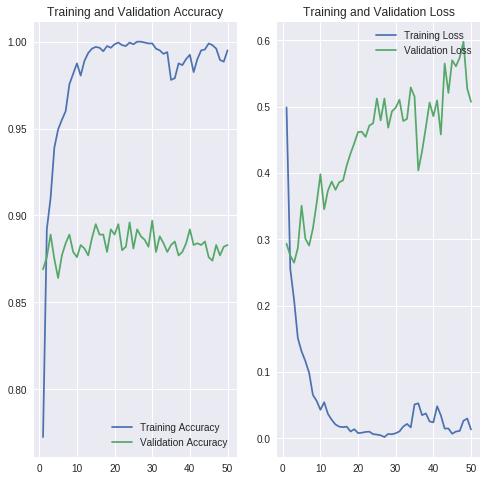

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Pretty cool, right? Already, our validation accuracy is above our previous notebook. Notice we're still overfitting almost immediately.  Now, let's employ the second approach, using data augmentation. First, let's build a new model by extending VGG. Because models behave just like layers, you can add a model (like our conv_base) to a Sequential model just like you would add a layer. So you can do the following:

In [0]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

Here's how our model looks now.

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 18,910,017
Trainable params: 18,910,017
Non-trainable params: 0
_________________________________________________________________


Before we train our model, we need to "freeze" the convolutional base (this prevents it from being updated during training).  Since the Dense layers we've added have their weights initialized randomly, they will make large errors initially, and the gradient in turn would be propagated backward through VGG (causing erroneously large updates to already useful weights)

In [0]:
conv_base.trainable = False

In [18]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=train_dir, 
    shuffle=True, 
    target_size=(TARGET_SHAPE,TARGET_SHAPE),
    class_mode='binary')

# Validation data should not be augmented!
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=validation_dir, 
    target_size=(TARGET_SHAPE, TARGET_SHAPE),
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Let's compile and train our model. This will be quite slow. Now would be a good time to get a cup of coffee.

In [19]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

# Now is a good time for a cup of coffee
history = model.fit_generator(
      train_data_gen,
      steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
      epochs=EPOCHS,
      validation_data=val_data_gen,
      validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
      verbose=2)

Epoch 1/50
32/32 [==============================] - 6s 190ms/step - loss: 0.3579 - acc: 0.8450
 - 25s - loss: 0.5953 - acc: 0.7550 - val_loss: 0.3579 - val_acc: 0.8450
Epoch 2/50
32/32 [==============================] - 6s 185ms/step - loss: 0.3068 - acc: 0.8620
 - 22s - loss: 0.3793 - acc: 0.8205 - val_loss: 0.3068 - val_acc: 0.8620
Epoch 3/50
32/32 [==============================] - 6s 186ms/step - loss: 0.2733 - acc: 0.8810
 - 22s - loss: 0.3551 - acc: 0.8335 - val_loss: 0.2733 - val_acc: 0.8810
Epoch 4/50
32/32 [==============================] - 6s 187ms/step - loss: 0.2992 - acc: 0.8690
 - 22s - loss: 0.3391 - acc: 0.8535 - val_loss: 0.2992 - val_acc: 0.8690
Epoch 5/50
32/32 [==============================] - 6s 185ms/step - loss: 0.2614 - acc: 0.8870
 - 22s - loss: 0.3656 - acc: 0.8400 - val_loss: 0.2614 - val_acc: 0.8870
Epoch 6/50
32/32 [==============================] - 6s 196ms/step - loss: 0.2932 - acc: 0.8700
 - 23s - loss: 0.3479 - acc: 0.8405 - val_loss: 0.2932 - val_acc:

## Results for approach two

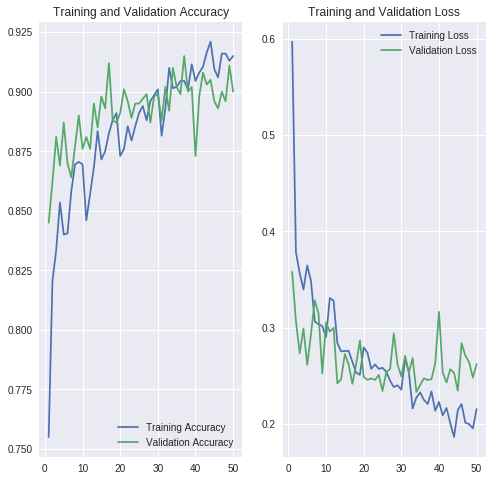

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Progress (but a small absolute improvement). To go further, we could employ fine tuning. To learn more about it, check out Deep Learning with Python, by François Chollet.